# Power Outages
This project uses major power outage data in the continental U.S. from January 2000 to July 2016. Here, a major power  outage is defined as a power outage that impacted at least 50,000 customers or caused an unplanned firm load loss of atleast 300MW. Interesting questions to consider include:
- Where and when do major power outages tend to occur?
- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?
- What characteristics are associated with each category of cause?
- How have characteristics of major power outages changed over time? Is there a clear trend?

### Getting the Data
The data is downloadable [here](https://engineering.purdue.edu/LASCI/research-data/outages/outagerisks).

A data dictionary is available at this [article](https://www.sciencedirect.com/science/article/pii/S2352340918307182) under *Table 1. Variable descriptions*.

### Cleaning and EDA
- Note that the data is given as an Excel file rather than a CSV. Open the data in Excel or another spreadsheet application and determine which rows and columns of the Excel spreadsheet should be ignored when loading the data in pandas.
- Clean the data.
    - The power outage start date and time is given by `OUTAGE.START.DATE` and `OUTAGE.START.TIME`. It would be preferable if these two columns were combined into one datetime column. Combine `OUTAGE.START.DATE` and `OUTAGE.START.TIME` into a new datetime column called `OUTAGE.START`. Similarly, combine `OUTAGE.RESTORATION.DATE` and `OUTAGE.RESTORATION.TIME` into a new datetime column called `OUTAGE.RESTORATION`.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.

*Hint 1: pandas can load multiple filetypes: `pd.read_csv`, `pd.read_excel`, `pd.read_html`, `pd.read_json`, etc.*

*Hint 2: `pd.to_datetime` and `pd.to_timedelta` will be useful here.*

*Tip: To visualize geospatial data, consider [Folium](https://python-visualization.github.io/folium/) or another geospatial plotting library.*

### Assessment of Missingness
- Assess the missingness of a column that is not missing by  design.

### Hypothesis Test
Find a hypothesis test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
The dataset I am using contains information on power outages that occurred in the U.S. in different states. This data contains information related to the major outages across the U.S. including characteristics of the states like energy consumption and population. Also included, are information of when the outage took place, the severity, and cause. This information can be used to explore a wide range of patterns and questions. The question I am investigating is: do certain causes of the outage have an affect on the timing of the outage? For example, causes like storms or natural disasters may have a greater affect on how long the outage lasts compared to that of equipment failure or vandalism. Moreover, certain causes may occur more frequently in certain parts of the day than others. So, the data on how the outages occurred and also the timing of the outages is related to my question of interest.

### Cleaning and EDA
The first thing I did was combine OUTAGE.START.DATE and OUTAGE.START.TIME into one column as well as OUTAGE.RESTORATION.DATE and OUTAGE.RESTORATION.TIME. Doing so allowed me to create a new column that indicated the period of day when the outage occurred. This helped answering the question of when each cause occurred. Also, to make it easier, I kept relevant rows and assigned it to a new dataframe, df2. Additionally, I created a new column indicating whether the values in the CAUSE.CATEGORY column was 'severe weather' or not. This was for the hypothesis testing. I did not drop any rows or replace any values as it did not do anything for my analysis.

Next, I performed univariate and bivariate analysis. I created a bar plot of the occurrences of the different causes. From this, I noticed that severe weather was the leading cause of outages. I also create a histogram of the outage duration times and observed that there were a few outliers in the data. This was also indicated by lookng at statistics from the describe() function. For the bivariate analysis, I plotted the distribution of duration times during different parts of the day and saw that the distributions were very similar with the am distribution having a smaller variance. I also plotted the same distribution of duration times except for each cause. They seemed to have similar distributions.

Looking at the aggregate statistics, I observed the average duration grouped by category. I observed that fuel supply emergency has the highest average duration time followed by severe weather, and islanding with the lowest average. I also took a look at the number of times each caused occurred by the time period.

### Assessment of Missingness
I believe that the data is MAR. This is because for certain variables such as CAUSE.CATEGORY.DETAIL, the cause may be unknown. So the missingness of this variable isn't explained by the actual category instead, it may depened on other columns like the population of the area or anomaly level. 

I ran two permutation tests on two different columns and found that one of them depended on CAUSE.CATEGORY and the other did not. For the first test, I tested the missingness of the CAUSE.CATEGORY.DETAIL column to see if it was dependent of CAUSE.CATEGORY. I rejected the null with significance level of 0.05 and concluded that the column does depend on CAUSE.CATEGORY. For the second test, I assessed the column OUTAGE.DURATION, and failed to reject the null hypothesis. So I was not able to say that the column depended on CAUSE.CATEGORY. For both tests, I used the TVD test statistic.

### Hypothesis Test
The question I pursued was if there is a relationship between the duration of the power outages and the cause. So, the null hypothesis is: the duration of the power outages caused by severe weather are the same as the duration of power outages not caused by severe weather. The alternative hypothesis is: outages caused by severe weather has a longer duration on average. Since the distributions are numerical I decided on the difference in means as my test statistic and a significance level of 0.05. To test my hypothesis, I ran a permutation test with 500 simulations. As a result, I got a p-value of 0, so I rejected the null hypothesis. I concluded that power outages caused by severe weather has a longer duration according to the alternative hypothesis.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from datetime import datetime, date
import folium

### Cleaning and EDA

In [2]:
# read in the data
df = pd.read_excel('outage.xlsx', skiprows=[0,1,2,3,4])
# drop unnecessary columns
df = df.drop(columns=['variables', 'OBS']).drop(index=0)
df1 = df.copy()

In [3]:
# convert to datetime object
start_dates = pd.to_datetime(df['OUTAGE.START.DATE']).astype(str)
start_times = (df['OUTAGE.START.TIME']).astype(str)

restore_dates = pd.to_datetime(df['OUTAGE.RESTORATION.DATE']).astype(str)
restore_times = (df['OUTAGE.RESTORATION.TIME']).astype(str)

# combine datetimes
outage_start = pd.to_datetime(start_dates + ' ' + start_times, errors='coerce')
outage_restoration = pd.to_datetime(restore_dates + ' ' + restore_times, errors='coerce')

After adding the columns, we'll take a look at what the dataframe looks like. There are two new columns: OUTAGE.START and OUTAGE.RESTORATION

In [4]:
# add the combined dates
df1['OUTAGE.START'] = outage_start
df1['OUTAGE.RESTORATION'] = outage_restoration
# drop the columns that were combined
df1 = df1.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])

# convert OUTAGE.DURATION into int types
df1['OUTAGE.DURATION'] = df1['OUTAGE.DURATION'].astype(float)
df1.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
4,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
5,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00


We'll create a new columns called START.TIME.PERIOD that indicates if the outage occurred in the am, afternoon, or pm. The result can be seen below

In [5]:
# indicate when the start was morning, afternoon, or night time
# AM if the time was between 5 am and 11 am
# Afternoon if the time was between 11 am and 5 pm
# PM if the time was between 5 pm and 5 am
start_time_period = df1['OUTAGE.START'].dt.time.apply(lambda x: 'AM' if x.hour >= 5 and x.hour <= 11 else ('Afternoon' if x.hour > 11 and x.hour <= 17 else('PM' if x.hour > 17 or x.hour <= 5 else x)))

# add start_time_period column to dataframe
df1['START.TIME.PERIOD'] = start_time_period
df1.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION,START.TIME.PERIOD
1,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00,Afternoon
2,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00,PM
3,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00,PM
4,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00,PM
5,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00,PM


We'll get relevant columns that pertain to the question. These columns include the causes of the outage and the timing such as duration, start, and restoration time

In [6]:
# Get relevant columns to the question of interest and store it in a new variable called df2
df2 = df1[['YEAR', 'U.S._STATE', 'POSTAL.CODE', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION','OUTAGE.START', 'OUTAGE.RESTORATION', 'START.TIME.PERIOD']]

In [7]:
# check for missing values
df2.isna().mean()

YEAR                     0.000000
U.S._STATE               0.000000
POSTAL.CODE              0.000000
CAUSE.CATEGORY           0.000000
CAUSE.CATEGORY.DETAIL    0.307040
OUTAGE.DURATION          0.037810
OUTAGE.START             0.005867
OUTAGE.RESTORATION       0.037810
START.TIME.PERIOD        0.005867
dtype: float64

We will create a dataframe for the hypothesis test by creating a new column indicating whether or not the cause is 'severe weather'. We will assign this dataframe into a variable called df3

In [8]:
# indicate if the value is 'severe weather'
is_severe = df2['CAUSE.CATEGORY'].apply(lambda x: True if x == 'severe weather' else False)
# reassign the column and get OUTAGE.DURATION into df3
df3 = df2.copy()[['OUTAGE.DURATION']]
df3['is_severe'] = is_severe

### Univariate analysis

We'll take a look at a bar plot of the occurrences of the different causes. We can see that severe weather seems to be the leading cause of outages in the U.S. followed by intentional attacks.

<AxesSubplot:title={'center':'Distribution of Causes'}>

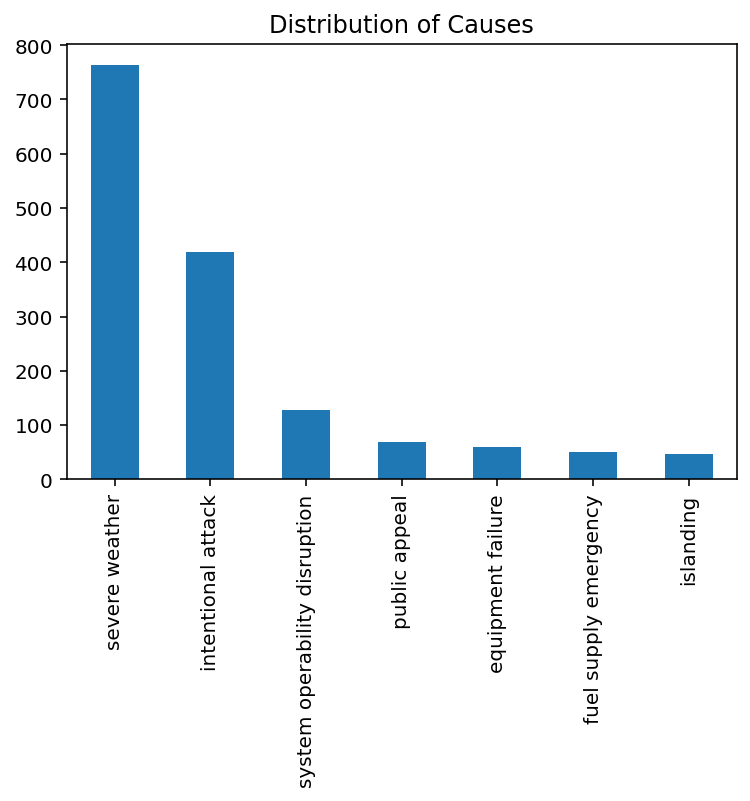

In [9]:
df2['CAUSE.CATEGORY'].value_counts().plot(kind='bar', title='Distribution of Causes')

We'll take a look at the distribution of outage duration times. We can see that there are a few outliers in the histogram

<AxesSubplot:title={'center':'Distribution of Outage Duration Times in Minutes'}, ylabel='Frequency'>

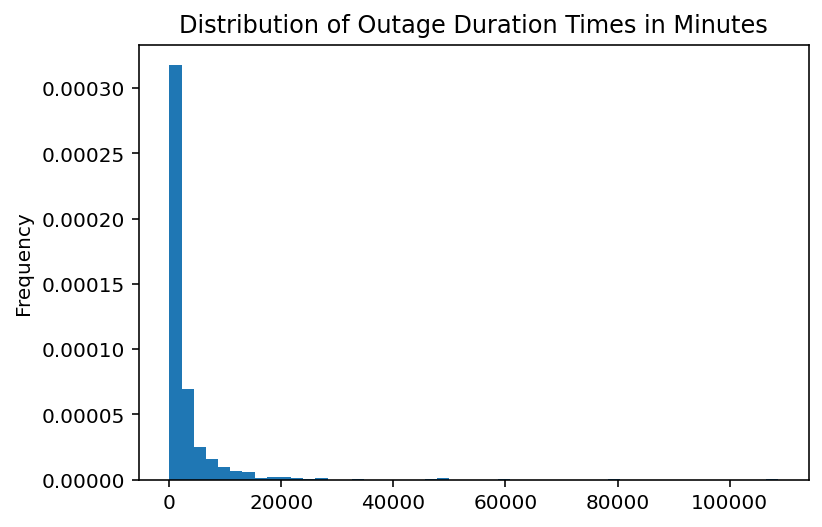

In [10]:
df2['OUTAGE.DURATION'].plot(kind='hist', density=True, bins=50, title='Distribution of Outage Duration Times in Minutes')

We can see from the describe() function that the max is 108653 minutes while the mean is around 2625 minutes. So there seems to be some outliers in the data.

In [11]:
df2['OUTAGE.DURATION'].dropna().astype(int).describe()

count      1476.000000
mean       2625.398374
std        5942.483307
min           0.000000
25%         102.250000
50%         701.000000
75%        2880.000000
max      108653.000000
Name: OUTAGE.DURATION, dtype: float64

### Bivariate analysis

We will take a look at the distribution of outage duration times during different parts of the day. We can see that the durations when the outage occurred in the afternoon and pm are very similar while the am times seem to have a smaller variance.

START.TIME.PERIOD
AM           AxesSubplot(0.125,0.125;0.775x0.755)
Afternoon    AxesSubplot(0.125,0.125;0.775x0.755)
PM           AxesSubplot(0.125,0.125;0.775x0.755)
Name: OUTAGE.DURATION, dtype: object

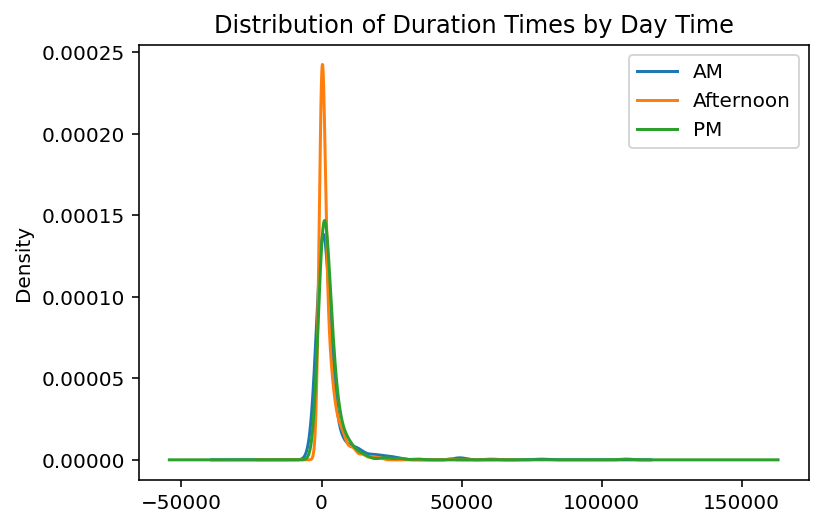

In [12]:
df2.groupby('START.TIME.PERIOD')['OUTAGE.DURATION'].plot(kind='kde', legend=True, title='Distribution of Duration Times by Day Time')

We will plot a histogram of the outage durations based on each category of cause. We can see that most of them are skewed right.

CAUSE.CATEGORY
equipment failure                AxesSubplot(0.125,0.125;0.775x0.755)
fuel supply emergency            AxesSubplot(0.125,0.125;0.775x0.755)
intentional attack               AxesSubplot(0.125,0.125;0.775x0.755)
islanding                        AxesSubplot(0.125,0.125;0.775x0.755)
public appeal                    AxesSubplot(0.125,0.125;0.775x0.755)
severe weather                   AxesSubplot(0.125,0.125;0.775x0.755)
system operability disruption    AxesSubplot(0.125,0.125;0.775x0.755)
Name: OUTAGE.DURATION, dtype: object

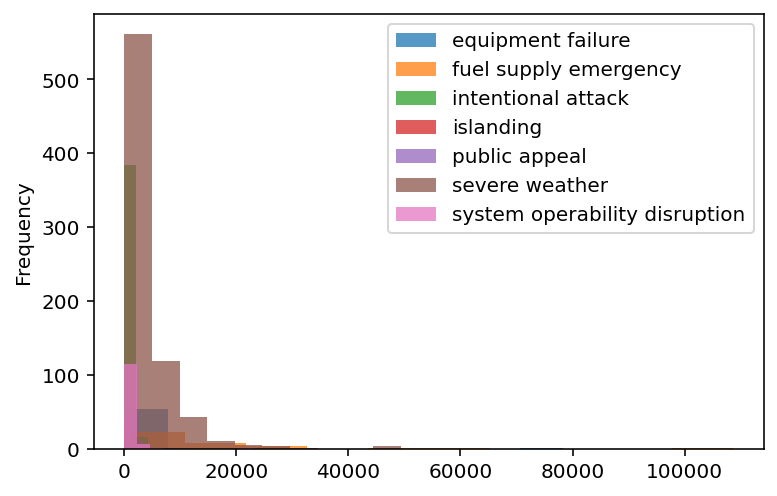

In [13]:
df2.groupby('CAUSE.CATEGORY')['OUTAGE.DURATION'].plot(kind='hist', density=False, alpha=0.75, legend=True)

### Aggregates

Now, we will take a look at some aggregate statistics. Below is the average duration grouped by category. We can see that fuel supply emergency has the highest average duration time followed by severe weather, and islanding with the lowest average

In [14]:
# look at aggregate statistics on outage duration by the cause and time of cause
df2.groupby('CAUSE.CATEGORY')['OUTAGE.DURATION'].mean()

CAUSE.CATEGORY
equipment failure                 1816.909091
fuel supply emergency            13484.026316
intentional attack                 429.980149
islanding                          200.545455
public appeal                     1468.449275
severe weather                    3883.985215
system operability disruption      728.869919
Name: OUTAGE.DURATION, dtype: float64

In [15]:
df2['CAUSE.CATEGORY'].value_counts()

severe weather                   763
intentional attack               418
system operability disruption    127
public appeal                     69
equipment failure                 60
fuel supply emergency             51
islanding                         46
Name: CAUSE.CATEGORY, dtype: int64

We will look at the the number of times each cause occurred by time period. We can see that many of the severe weather causes occurred at night and many of the intentional attacks occurred in the morning

In [16]:
# look at aggregate statistics on outage duration by the cause and time of cause
by_cause = df2.pivot_table(index='CAUSE.CATEGORY', columns='START.TIME.PERIOD',values='OUTAGE.DURATION', aggfunc='count')
by_cause

START.TIME.PERIOD,AM,Afternoon,PM
CAUSE.CATEGORY,,,
equipment failure,20,23,12
fuel supply emergency,20,12,6
intentional attack,164,150,89
islanding,8,18,18
public appeal,19,47,3
severe weather,173,255,316
system operability disruption,31,60,32


In [17]:
# df2['CAUSE.CATEGORY.DETAIL'] = df2['CAUSE.CATEGORY.DETAIL'].apply(lambda x: x.strip())
# df2[df2['CAUSE.CATEGORY.DETAIL'].str.contains('Coal')]['CAUSE.CATEGORY.DETAIL']

### Assessment of Missingness

Create a dataframe of the columns used to assess missingness

In [18]:
# get columns for assessing missingess
df_missing = df.copy()[['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL','OUTAGE.DURATION']]
df_missing.head()

,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION
1,severe weather,NaN,3060
2,intentional attack,vandalism,1
3,severe weather,heavy wind,3000
4,severe weather,thunderstorm,2550
5,severe weather,NaN,1740


Now, we will assess the missingness of CAUSE.CATEGORY.DETAIL, if it is dependent on the CAUSE.CATEGORY column through a permutation test.

In [19]:
# for category details

#indicate if the data is missing or not
df_missing['detail_missing'] = df_missing['CAUSE.CATEGORY.DETAIL'].isna()
detail_tvds = []
for _ in range(500):
    #shuffle the category
    df_missing['shuffled'] = np.random.permutation(df_missing['CAUSE.CATEGORY'])

    # compute TVD
    pivoted = df_missing.pivot_table(index='detail_missing', columns='shuffled', aggfunc='size').fillna(0).apply(lambda x: x/x.sum(), axis=1)
    tvd = pivoted.diff().iloc[-1].abs().sum() / 2

    # store tvd
    detail_tvds.append(tvd)

We can see from the p-value, that we reject the null hypothesis with a significance level of 0.05 that the distributions are the same. This means that the columns CAUSE.CATEGORY.DETAIL does depend on the column CAUSE.CATEGORY

In [20]:
# get the observed data
emp = df_missing.pivot_table(index='CAUSE.CATEGORY', columns='detail_missing', values=None, aggfunc='size').fillna(0).apply(lambda x: x/x.sum())
obs_tvd = emp.diff(axis=1).iloc[:,-1].abs().sum() / 2

# calculate pvalue
pval = (detail_tvds >= obs_tvd).mean()
pval
# reject the null. It didn't come from same distribution, so it does depend on each other

0.0

We will assess another column, OUTAGE.DURATION, on missingness following the same procedure from before.

In [21]:
# for customers affected

df_missing['duration_missing'] = df_missing['OUTAGE.DURATION'].isna()
customer_tvds = []
for _ in range(500):
    #shuffle the category
    df_missing['shuffled'] = np.random.permutation(df_missing['CAUSE.CATEGORY'])

    # compute TVD
    pivoted = df_missing.pivot_table(columns='duration_missing', index='shuffled', aggfunc='size').fillna(0).apply(lambda x: x/x.sum(), axis=1)

    tvd = pivoted.diff(axis=1).iloc[-1].abs().sum() / 2
    customer_tvds.append(tvd)

Here, the p-value is 1. So, we would fail to reject the null hypothesis with significance level 0.05. Because we failed to reject the null that the distributions are the same, we cannot say that the OUTAGE.DURATION column depends on CAUSE.CATEGORY

In [22]:
# get the observed tvd
emp = df_missing.pivot_table(index='CAUSE.CATEGORY', columns='duration_missing', aggfunc='size').fillna(0).apply(lambda x: x/x.sum())
obs_tvd = emp.diff(axis=1).iloc[:, -1].abs().sum() / 2

# calculate pvalue
pval = (customer_tvds >= obs_tvd).mean()
pval
# fail to reject the null, so the data does not depend on CAUSE.CATEGORY

1.0

### Hypothesis Test

Hypothesis: The duration of the power outages caused by severe weather are the same as the duration of power outages not caused by severe weather.


Alternative Hypothesis: Outages cause by severe weather has a longer duration on average.

Test statistic: Difference in means. We will use difference in means since the two distributions are numerical

Significance level: 0.05

Now, we will perform a hypothesis test to see if outages cause by severe weather is the same as other causes. We will use the df3 dataframe created in the cleaning process

We will now perform the test to see if the duration is the same when caused by severe weather.

In [23]:
# perform permutation test
diffs = []

# simulate 500 times
for _ in range(500):
    # shuffle the duration column
    shuffled_duration = df3['OUTAGE.DURATION'].sample(frac=1).reset_index(drop=True)

    # assign the shuffled column to df3
    df3['shuffled_duration'] = shuffled_duration

    # calculate the test statistic
    group_means = df3.groupby('is_severe').mean().loc[:, 'shuffled_duration']
    diff_means = group_means.diff().iloc[-1]

    # add test statistic to list
    diffs.append(diff_means)

After running the test, we get a p-value of 0. So, we reject the null hypothesis with significance level 0.05 that the power outages caused by severe weather is the same as power outages not caused by severe weather. It seems that power outages caused by severe weather has a longer duration according to the alternative hypothesis.

In [24]:
# calculate observed difference
obs_diff = df3.groupby('is_severe').mean().loc[:, 'OUTAGE.DURATION'].diff().iloc[-1]

pval = (diffs >= obs_diff).mean()
pval
# We reject the null that the power outages caused by severe weather is the same as power outages not caused by severe weather. So, it seems that outages caused by severe weather has a longer duration according to the alternative hypothesis.

0.0